### Importing Libraries

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import random

import sys
import sklearn
import pandas as pd
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns

### Loading the Data- CIFAR10

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize with mean 0.5 and standard deviation 0.5 for 3 channels Red, Green and Blue

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
# Getting Validation set
from torch.utils.data import random_split
val_size = 10000
train_size = len(trainset) - val_size
train_data,val_data = random_split(trainset,[train_size,val_size])

In [4]:
trainloader=torch.utils.data.DataLoader(train_data, batch_size=32,shuffle=True, num_workers=2)
valloader=torch.utils.data.DataLoader(val_data, batch_size=32,shuffle=True, num_workers=2)

In [5]:
def imshow(img):
#     the transform-normalize will change the size of the image
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig,ax = plt.subplots(figsize = (16,12))
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Now the image is of 32x32x3
    plt.show()

In [6]:
# getting random images
dataiter = iter(trainloader)

In [7]:
images, labels = dataiter.next()  # __next__() returns the next item in the sequence

In [8]:
print("The shape of the images: ",images.shape)
print('\nThis means that there are is a batch of',images.shape[0], 'images of 3x32x32')

The shape of the images:  torch.Size([32, 3, 32, 32])

This means that there are is a batch of 32 images of 3x32x32


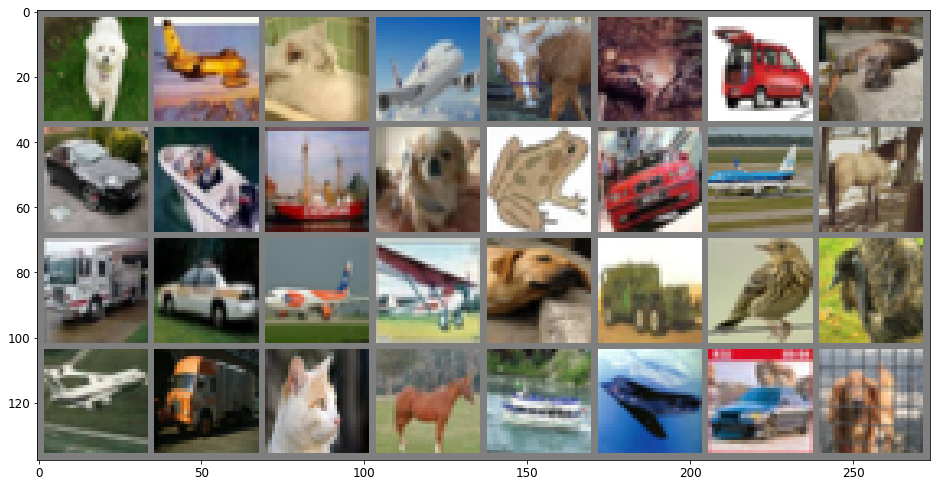

  dog plane   cat plane


In [9]:
# show images
imshow(torchvision.utils.make_grid(images)) # make grid will restore the original size that is before normalization
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Baseline for Convolutional Neural Network

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [11]:
def baseline():
    baseline_model=nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
        
    nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
        
    nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
        
    nn.Flatten(),
    nn.Linear(32*4*4, 10),  
    nn.Softmax(dim=1)
    )
    
    classification_loss = nn.CrossEntropyLoss() # We usually use crossEntrophy loss for classification problems

    return baseline_model, classification_loss

In [12]:
base_model, classification_loss = baseline()

In [13]:
def optimizers(model, opt, learning_rate, momentum_value=0):
    
    if opt =="SGD":
        model_optimizer = optim.SGD(model.parameters(), learning_rate, momentum=momentum_value)
        
    elif opt=="Adam":
        model_optimizer = optim.Adam(model.parameters(), learning_rate)
    
    return model_optimizer

In [14]:
# I am using Macbook for this assignment
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
base_model.to(device)
print(device)


mps


In [15]:
def train(loader, model, classify_loss, opt):
    
    total = 0
    correct = 0
    running_loss = 0.0
    
    model.train()
    
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()  # zero the parameter gradients

        # forward + backward + optimize
        outputs = model(inputs)
        loss = classify_loss(outputs, labels)
        loss.backward()
        opt.step() 
        
        
        # Loss
        running_loss += loss.item()
            
        _, predicted = torch.max(outputs.data, 1)
#         predicted = outputs.argmax(1) 

        total += labels.size(0)
        correct += (predicted == labels).sum().item() 
        
        
    running_loss = running_loss / len(loader)

    accuracy=correct/total

    
    return running_loss, accuracy


In [16]:
# We dont need backprop here
def validation(loader, model, classify_loss, opt):

    total = 0
    correct = 0
    running_loss = 0.0
    
    model.eval()
    
    with torch.no_grad():
    
        for i, data in enumerate(loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = classify_loss(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item() 

    running_loss = running_loss / len(loader)
#     accuracy= 100 * correct / total
    accuracy=correct/total
    
    return running_loss, accuracy

### Function for performance matrics

In [17]:
def performance_metrics(optim, lr,  epochs=20,momentum=0):
    
    tr_loss=[]
    tr_acc=[]
    val_loss=[]
    val_acc=[]
    
    base_model, classification_loss = baseline()
    optimizer=optimizers(model=base_model, opt=optim, learning_rate=lr)
    
    base_model = base_model.to(device)

    for epoch in range(epochs):
        loss_tr,acc_tr=train(loader=trainloader, model=base_model, classify_loss=classification_loss, opt=optimizer)
        
        loss_val,acc_val=validation(loader=valloader, model=base_model, classify_loss=classification_loss, opt=optimizer)
       
        print("Epoch Number: ",epoch+1)
        print("\nTraining Loss: ",loss_tr)
        print("Training Accuracy: ",acc_tr)
        
        print("\nValidation Loss",loss_val)
        print("Validation Accuracy",acc_val)

        tr_loss.append(loss_tr)
        tr_acc.append(acc_tr)
        val_loss.append(loss_val)
        val_acc.append(acc_val)

        print('-----------------------------------')


    plt.figure(figsize=[10,5])

    plt.plot(tr_loss, linestyle='-',label="Training Loss")
    plt.plot(tr_acc,label="Training Accuracy")
    plt.plot(val_loss, label='Validation Loss')
    plt.plot(val_acc, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy And Loss')
    plt.xticks(np.arange(1,21,1))
    plt.legend(loc='center right')
    plt.show()

## Optimizer ==SGD

### Optimizer = SGD  & Learning Rate=0.01

Epoch Number:  1

Training Loss:  2.301432427406311
Training Accuracy:  0.1375

Validation Loss 2.2995565006146417
Validation Accuracy 0.1594
-----------------------------------
Epoch Number:  2

Training Loss:  2.2851717811584473
Training Accuracy:  0.171325

Validation Loss 2.2495632377295447
Validation Accuracy 0.1964
-----------------------------------
Epoch Number:  3

Training Loss:  2.211133926200867
Training Accuracy:  0.240675

Validation Loss 2.1843450861617018
Validation Accuracy 0.2754
-----------------------------------
Epoch Number:  4

Training Loss:  2.165423924064636
Training Accuracy:  0.29015

Validation Loss 2.148770435930441
Validation Accuracy 0.3079
-----------------------------------
Epoch Number:  5

Training Loss:  2.1387213247299193
Training Accuracy:  0.317575

Validation Loss 2.130360713782021
Validation Accuracy 0.3271
-----------------------------------
Epoch Number:  6

Training Loss:  2.121643184375763
Training Accuracy:  0.334575

Validation Loss 2.121

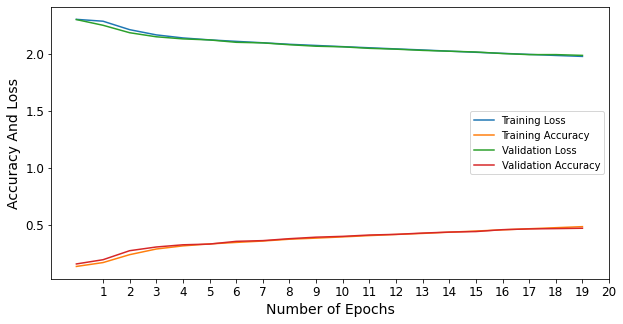

In [18]:
performance_metrics(optim="SGD", lr=0.01)

Epoch Number:  1

Training Loss:  2.3021131004333495
Training Accuracy:  0.12105

Validation Loss 2.301502606358391
Validation Accuracy 0.1393
-----------------------------------
Epoch Number:  2

Training Loss:  2.300527159500122
Training Accuracy:  0.144675

Validation Loss 2.29872978761935
Validation Accuracy 0.159
-----------------------------------
Epoch Number:  3

Training Loss:  2.2914729928970337
Training Accuracy:  0.161025

Validation Loss 2.270685032914622
Validation Accuracy 0.1763
-----------------------------------
Epoch Number:  4

Training Loss:  2.2215394638061525
Training Accuracy:  0.233375

Validation Loss 2.188680312884882
Validation Accuracy 0.2679
-----------------------------------
Epoch Number:  5

Training Loss:  2.1657624348640443
Training Accuracy:  0.289425

Validation Loss 2.142503328597584
Validation Accuracy 0.3171
-----------------------------------
Epoch Number:  6

Training Loss:  2.1276966547966003
Training Accuracy:  0.3293

Validation Loss 2.11345

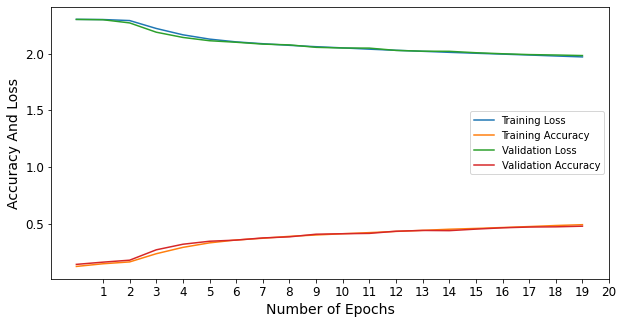

In [19]:
performance_metrics(optim="SGD", lr=0.01, momentum=0.9)

### Optimizer =SGD & Learning rate= 0.001

Epoch Number:  1

Training Loss:  2.3024561107635497
Training Accuracy:  0.09725

Validation Loss 2.3023782332484335
Validation Accuracy 0.0989
-----------------------------------
Epoch Number:  2

Training Loss:  2.3023245349884034
Training Accuracy:  0.0978

Validation Loss 2.3022476971720733
Validation Accuracy 0.1006
-----------------------------------
Epoch Number:  3

Training Loss:  2.3021865917205813
Training Accuracy:  0.099525

Validation Loss 2.3021092856653964
Validation Accuracy 0.1044
-----------------------------------
Epoch Number:  4

Training Loss:  2.3020397893905638
Training Accuracy:  0.10345

Validation Loss 2.3019571845142988
Validation Accuracy 0.1082
-----------------------------------
Epoch Number:  5

Training Loss:  2.301881019592285
Training Accuracy:  0.1082

Validation Loss 2.301790405005312
Validation Accuracy 0.1143
-----------------------------------
Epoch Number:  6

Training Loss:  2.301706435585022
Training Accuracy:  0.112825

Validation Loss 2.301

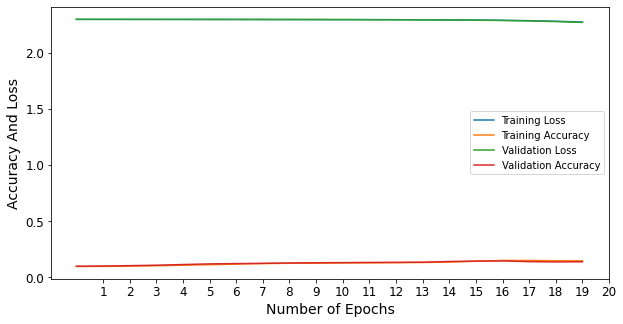

In [20]:
performance_metrics(optim="SGD", lr=0.001)

Epoch Number:  1

Training Loss:  2.3025893575668337
Training Accuracy:  0.09765

Validation Loss 2.3025911882662546
Validation Accuracy 0.1
-----------------------------------
Epoch Number:  2

Training Loss:  2.3024685676574705
Training Accuracy:  0.101725

Validation Loss 2.30247539148544
Validation Accuracy 0.1031
-----------------------------------
Epoch Number:  3

Training Loss:  2.3023547857284545
Training Accuracy:  0.104475

Validation Loss 2.302361686389667
Validation Accuracy 0.1072
-----------------------------------
Epoch Number:  4

Training Loss:  2.302243669128418
Training Accuracy:  0.1079

Validation Loss 2.302252667399641
Validation Accuracy 0.11
-----------------------------------
Epoch Number:  5

Training Loss:  2.3021314804077146
Training Accuracy:  0.111025

Validation Loss 2.3021411316844222
Validation Accuracy 0.1145
-----------------------------------
Epoch Number:  6

Training Loss:  2.3020154445648195
Training Accuracy:  0.116

Validation Loss 2.3020172378

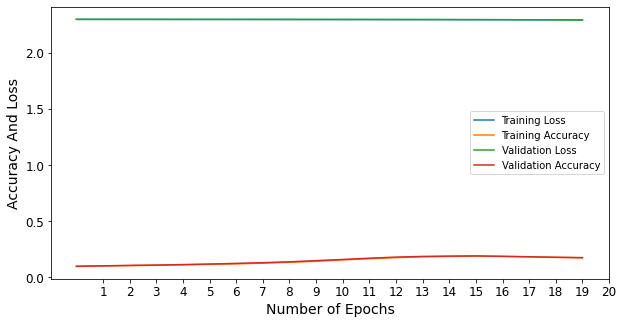

In [90]:
performance_metrics(optim="SGD", lr=0.001, momentum=0.9)

### Optimizer = SGD & Learning Rate=0.1

Epoch Number:  1

Training Loss:  2.216215696811676
Training Accuracy:  0.222675

Validation Loss 2.1314521475721855
Validation Accuracy 0.3235
-----------------------------------
Epoch Number:  2

Training Loss:  2.0746528747558592
Training Accuracy:  0.3803

Validation Loss 2.0223035599096133
Validation Accuracy 0.4404
-----------------------------------
Epoch Number:  3

Training Loss:  2.016806706047058
Training Accuracy:  0.439625

Validation Loss 2.0101658086807204
Validation Accuracy 0.4466
-----------------------------------
Epoch Number:  4

Training Loss:  1.9765469935417175
Training Accuracy:  0.4806

Validation Loss 1.9618508796722363
Validation Accuracy 0.4961
-----------------------------------
Epoch Number:  5

Training Loss:  1.9397127471923827
Training Accuracy:  0.51915

Validation Loss 1.9517659463059789
Validation Accuracy 0.506
-----------------------------------
Epoch Number:  6

Training Loss:  1.9027312540054322
Training Accuracy:  0.556025

Validation Loss 1.91

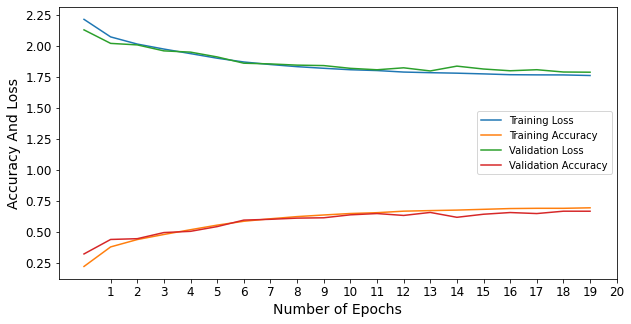

In [22]:
performance_metrics(optim="SGD", lr=0.1)

Epoch Number:  1

Training Loss:  2.1882299968719483
Training Accuracy:  0.260575

Validation Loss 2.1031829827128887
Validation Accuracy 0.3521
-----------------------------------
Epoch Number:  2

Training Loss:  2.065198800563812
Training Accuracy:  0.390475

Validation Loss 2.0227824190554147
Validation Accuracy 0.4334
-----------------------------------
Epoch Number:  3

Training Loss:  2.0118738256454467
Training Accuracy:  0.445225

Validation Loss 1.978850346403762
Validation Accuracy 0.4793
-----------------------------------
Epoch Number:  4

Training Loss:  1.9700576561927796
Training Accuracy:  0.487825

Validation Loss 1.9808222344889046
Validation Accuracy 0.476
-----------------------------------
Epoch Number:  5

Training Loss:  1.9304705123901367
Training Accuracy:  0.529375

Validation Loss 1.9250723538688197
Validation Accuracy 0.5346
-----------------------------------
Epoch Number:  6

Training Loss:  1.8998396689414978
Training Accuracy:  0.559025

Validation Loss

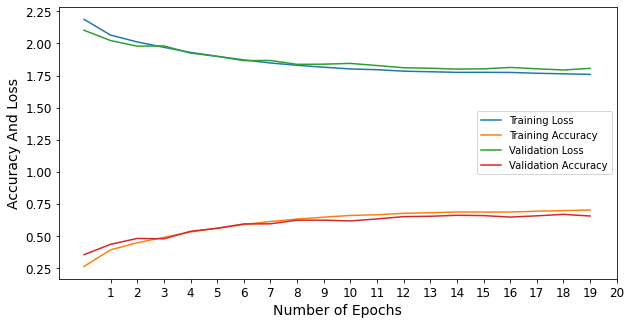

In [91]:
performance_metrics(optim="SGD", lr=0.1, momentum=0.9)

## Optimizer= Adam

### Optimizer= Adam & Learning rate=0.01

Epoch Number:  1

Training Loss:  2.3553373846054075
Training Accuracy:  0.10475

Validation Loss 2.358913747647319
Validation Accuracy 0.1024
-----------------------------------
Epoch Number:  2

Training Loss:  2.3617501693725584
Training Accuracy:  0.0994

Validation Loss 2.358913747647319
Validation Accuracy 0.1024
-----------------------------------
Epoch Number:  3

Training Loss:  2.3617501693725584
Training Accuracy:  0.0994

Validation Loss 2.3585143866249547
Validation Accuracy 0.1024
-----------------------------------
Epoch Number:  4

Training Loss:  2.3617501693725584
Training Accuracy:  0.0994

Validation Loss 2.3586142268805457
Validation Accuracy 0.1024
-----------------------------------
Epoch Number:  5

Training Loss:  2.3617501693725584
Training Accuracy:  0.0994

Validation Loss 2.358714067136137
Validation Accuracy 0.1024
-----------------------------------
Epoch Number:  6

Training Loss:  2.3617501693725584
Training Accuracy:  0.0994

Validation Loss 2.35871406

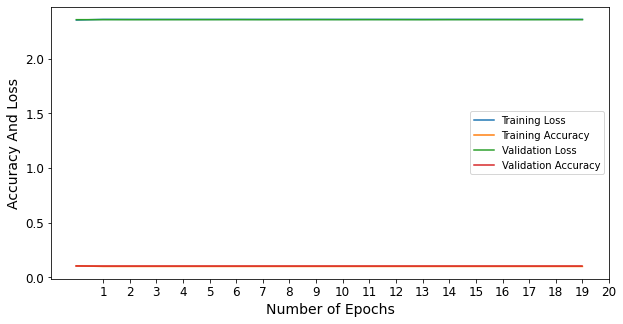

In [24]:
performance_metrics(optim="Adam", lr=0.01)

### Optimizer = Adam & Learning Rate=0.001

Epoch Number:  1

Training Loss:  2.080891403198242
Training Accuracy:  0.373325

Validation Loss 1.9966626582435145
Validation Accuracy 0.4615
-----------------------------------
Epoch Number:  2

Training Loss:  1.9727733449935914
Training Accuracy:  0.48545

Validation Loss 1.9580990742570676
Validation Accuracy 0.4971
-----------------------------------
Epoch Number:  3

Training Loss:  1.9242820713996887
Training Accuracy:  0.5342

Validation Loss 1.909422766286344
Validation Accuracy 0.5498
-----------------------------------
Epoch Number:  4

Training Loss:  1.8872325076103211
Training Accuracy:  0.5716

Validation Loss 1.8797621308043362
Validation Accuracy 0.5783
-----------------------------------
Epoch Number:  5

Training Loss:  1.8571416739463806
Training Accuracy:  0.60265

Validation Loss 1.8724275305629157
Validation Accuracy 0.5868
-----------------------------------
Epoch Number:  6

Training Loss:  1.8387499335289001
Training Accuracy:  0.6204

Validation Loss 1.8444

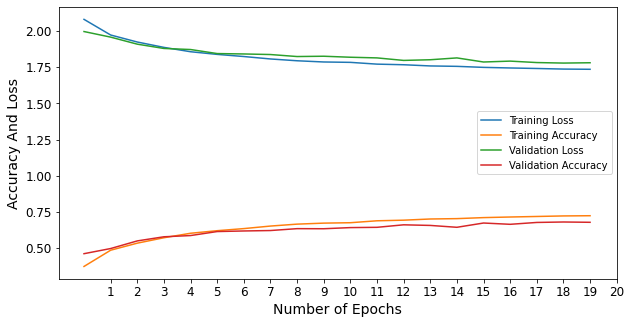

In [25]:
performance_metrics(optim="Adam", lr=0.001)

### Optimizer= Adam & Learning rate=0.1

Epoch Number:  1

Training Loss:  2.3614485807418824
Training Accuracy:  0.09965

Validation Loss 2.3599121502032294
Validation Accuracy 0.1012
-----------------------------------
Epoch Number:  2

Training Loss:  2.3614501693725587
Training Accuracy:  0.0997

Validation Loss 2.3599121502032294
Validation Accuracy 0.1012
-----------------------------------
Epoch Number:  3

Training Loss:  2.3614501693725587
Training Accuracy:  0.0997

Validation Loss 2.3600119904588204
Validation Accuracy 0.1012
-----------------------------------
Epoch Number:  4

Training Loss:  2.3614501693725587
Training Accuracy:  0.0997

Validation Loss 2.3600119904588204
Validation Accuracy 0.1012
-----------------------------------
Epoch Number:  5

Training Loss:  2.3614501693725587
Training Accuracy:  0.0997

Validation Loss 2.3598123099476385
Validation Accuracy 0.1012
-----------------------------------
Epoch Number:  6

Training Loss:  2.3614501693725587
Training Accuracy:  0.0997

Validation Loss 2.35991

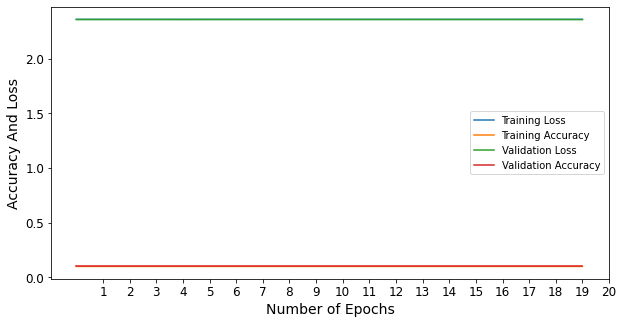

In [26]:
performance_metrics(optim="Adam", lr=0.1)

### Summary till now

In [3]:
data = {'Optimizer and Learning rate':['SGD 0.1 without momentum', 'SGD 0.1 with momentum' ,'SGD 0.01 without momentum','SGD 0.01 with momentum',
                                       'SGD 0.001 without momentum','SGD 0.001 with momentum',
                                       
                                       'ADAM 0.1','ADAM 0.01','ADAM 0.001'],
        
        
        'Training Loss':[1.76,1.75,1.97,1.97 , 2.27,  2.29, 
                         
                         2.36 ,2.36, 1.73],
        
        'Training Accuracy':[69.57,70.06,48.60,48.97 ,14.77, 17.43,
                             
                             9.97, 9.94, 72.38],
        
        'Validation Loss':[1.78,1.80,1.98, 1.98 ,2.27, 2.29,  
                           
                           2.35,  2.35,  1.78],
        
       'Validation_Accuracy':[66.82,65.41,47.20,47.64 , 13.87,  17.66, 
                              
                              10.12, 10.24,  67.84]}  

df = pd.DataFrame(data, index =['Case 1','Case 1.1', 'Case 2', 'Case 2.1', 'Case 3','Case 3.1' ,'Case 4',"Case 5","Case 6"])

# display(df)

def highlight_rows(x):
    if x.Validation_Accuracy>67:
        return['background-color: green']*5
    else:
        return['background-color: None']*5
display(df.style.apply(highlight_rows, axis = 1))

,Optimizer and Learning rate,Training Loss,Training Accuracy,Validation Loss,Validation_Accuracy
Case 1,SGD 0.1 without momentum,1.760000,69.570000,1.780000,66.820000
Case 1.1,SGD 0.1 with momentum,1.750000,70.060000,1.800000,65.410000
Case 2,SGD 0.01 without momentum,1.970000,48.600000,1.980000,47.200000
Case 2.1,SGD 0.01 with momentum,1.970000,48.970000,1.980000,47.640000
Case 3,SGD 0.001 without momentum,2.270000,14.770000,2.270000,13.870000
Case 3.1,SGD 0.001 with momentum,2.290000,17.430000,2.290000,17.660000
Case 4,ADAM 0.1,2.360000,9.970000,2.350000,10.120000
Case 5,ADAM 0.01,2.360000,9.940000,2.350000,10.240000
Case 6,ADAM 0.001,1.730000,72.380000,1.780000,67.840000


### From the table above we can see that for our architecture the best optimizer is adam with a learning rate of 0.001

## Creating other networks for comparision

#### Network 1

In [27]:
def network1():
    model1=nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),
    nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),  
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  
        
    nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1), 
    nn.ReLU(),
    nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(512,256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(256,128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(128,64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64,32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
        
#     nn.MaxPool2d(kernel_size=2, stride=2),


    nn.Flatten(),
    nn.Linear(32*2*2, 10),  
    nn.Softmax(dim=1)
    )

    classification_loss = nn.CrossEntropyLoss() # We usually use crossEntrophy loss for classification problems

    return model1, classification_loss

In [28]:
# model_net1, classification_loss_net1 = network1()

## Function for performance matrics for the network defined above

In [29]:
def performace_metrics2(optim,lr):
    
    tr_loss=[]
    tr_acc=[]
    val_loss=[]
    val_acc=[]
    
    model_net1, classification_loss_net1 = network1()
    optimizer=optimizers(model=model_net1, opt=optim, learning_rate=lr)
    
    model_net1 = model_net1.to(device)

    for epoch in range(3):
        loss_tr,acc_tr=train(loader=trainloader, model=model_net1, classify_loss=classification_loss_net1, opt=optimizer)
        
        loss_val,acc_val=validation(loader=valloader, model=model_net1, classify_loss=classification_loss_net1, opt=optimizer)
       
        print("Epoch Number: ",epoch+1)
        print("\nTraining Loss: ",loss_tr)
        print("Training Accuracy: ",acc_tr)
        
        print("\nValidation Loss",loss_val)
        print("Validation Accuracy",acc_val)

        tr_loss.append(loss_tr)
        tr_acc.append(acc_tr)
        val_loss.append(loss_val)
        val_acc.append(acc_val)

        print('-----------------------------------')


    plt.figure(figsize=[10,5])

    plt.plot(tr_loss, linestyle='-',label="Training Loss")
    plt.plot(tr_acc,label="Training Accuracy")
    plt.plot(val_loss, label='Validation Loss')
    plt.plot(val_acc, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy And Loss')
    plt.xticks(np.arange(0,4,1))
#     plt.yticks(np.arange(0.1,,5))
    plt.legend(loc='center right')
    plt.show()

### SGD 0.1

Epoch Number:  1

Training Loss:  2.302601322937012
Training Accuracy:  0.101375

Validation Loss 2.302634116559745
Validation Accuracy 0.0945
-----------------------------------
Epoch Number:  2

Training Loss:  2.3025922395706178
Training Accuracy:  0.101375

Validation Loss 2.3026604111583087
Validation Accuracy 0.0945
-----------------------------------
Epoch Number:  3

Training Loss:  2.3025859355926515
Training Accuracy:  0.101375

Validation Loss 2.302682196370329
Validation Accuracy 0.0945
-----------------------------------


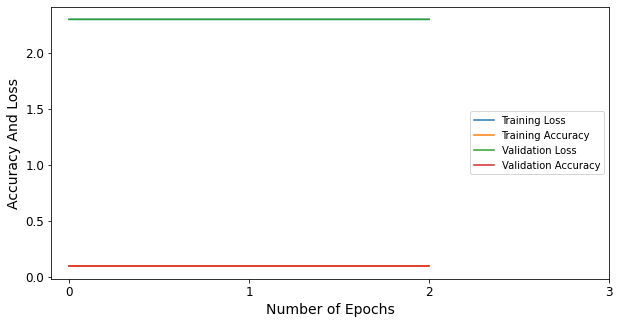

In [30]:
performace_metrics2(optim='SGD',lr=0.1)

### SGD 0.01

Epoch Number:  1

Training Loss:  2.3026087913513185
Training Accuracy:  0.099975

Validation Loss 2.302552962074645
Validation Accuracy 0.1001
-----------------------------------
Epoch Number:  2

Training Loss:  2.30260706577301
Training Accuracy:  0.099975

Validation Loss 2.302555476514676
Validation Accuracy 0.1001
-----------------------------------
Epoch Number:  3

Training Loss:  2.3026055284500124
Training Accuracy:  0.099975

Validation Loss 2.3025587153510925
Validation Accuracy 0.1001
-----------------------------------


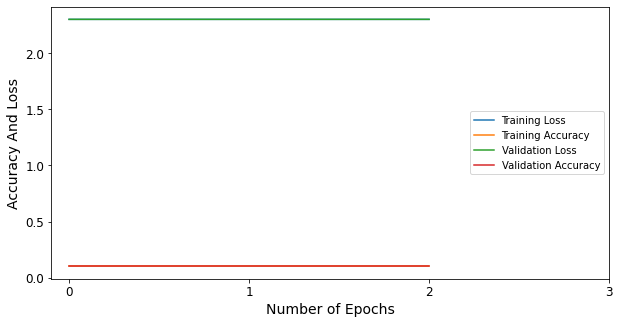

In [31]:
performace_metrics2(optim='SGD',lr=0.01)

### SDG 0.001

Epoch Number:  1

Training Loss:  2.3025826808929444
Training Accuracy:  0.101375

Validation Loss 2.302629891295022
Validation Accuracy 0.0945
-----------------------------------
Epoch Number:  2

Training Loss:  2.3025825639724733
Training Accuracy:  0.101375

Validation Loss 2.3026339139420386
Validation Accuracy 0.0945
-----------------------------------
Epoch Number:  3

Training Loss:  2.3025824634552
Training Accuracy:  0.101375

Validation Loss 2.3026360444748364
Validation Accuracy 0.0945
-----------------------------------


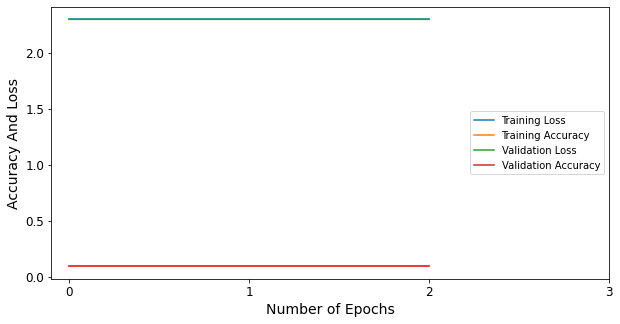

In [32]:
performace_metrics2(optim='SGD',lr=0.001)

### ADAM 0.1

Epoch Number:  1

Training Loss:  2.361424133682251
Training Accuracy:  0.099625

Validation Loss 2.3601118307144118
Validation Accuracy 0.1012
-----------------------------------
Epoch Number:  2

Training Loss:  2.3614501693725587
Training Accuracy:  0.0997

Validation Loss 2.3597124696920475
Validation Accuracy 0.1012
-----------------------------------
Epoch Number:  3

Training Loss:  2.3614501693725587
Training Accuracy:  0.0997

Validation Loss 2.3598123099476385
Validation Accuracy 0.1012
-----------------------------------


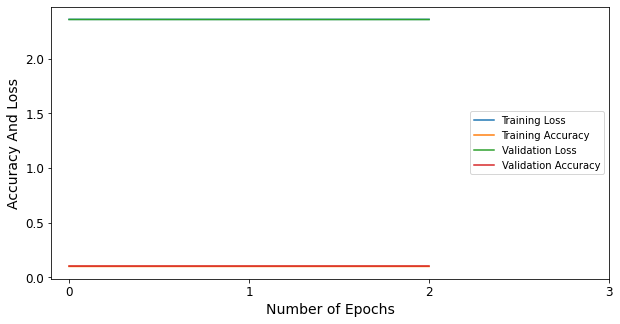

In [33]:
performace_metrics2(optim='Adam',lr=0.1)

### ADAM 0.01

Epoch Number:  1

Training Loss:  2.361773127365112
Training Accuracy:  0.09935

Validation Loss 2.358913747647319
Validation Accuracy 0.1022
-----------------------------------
Epoch Number:  2

Training Loss:  2.3617001693725586
Training Accuracy:  0.09945

Validation Loss 2.358913747647319
Validation Accuracy 0.1022
-----------------------------------
Epoch Number:  3

Training Loss:  2.3617001693725586
Training Accuracy:  0.09945

Validation Loss 2.359113428158501
Validation Accuracy 0.1022
-----------------------------------


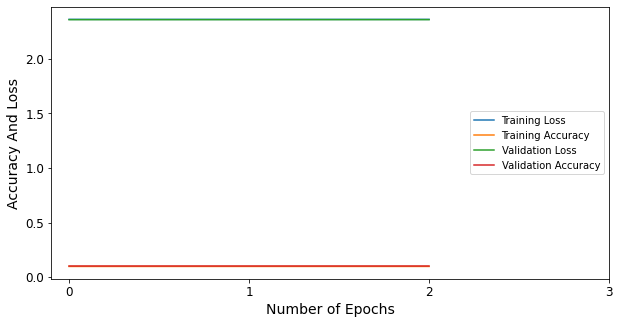

In [34]:
performace_metrics2(optim='Adam',lr=0.01)

### ADAM 0.001

Epoch Number:  1

Training Loss:  2.2901459993362425
Training Accuracy:  0.151525

Validation Loss 2.358913747647319
Validation Accuracy 0.1024
-----------------------------------
Epoch Number:  2

Training Loss:  2.3617501693725584
Training Accuracy:  0.0994

Validation Loss 2.358913747647319
Validation Accuracy 0.1024
-----------------------------------
Epoch Number:  3

Training Loss:  2.3617501693725584
Training Accuracy:  0.0994

Validation Loss 2.358913747647319
Validation Accuracy 0.1024
-----------------------------------


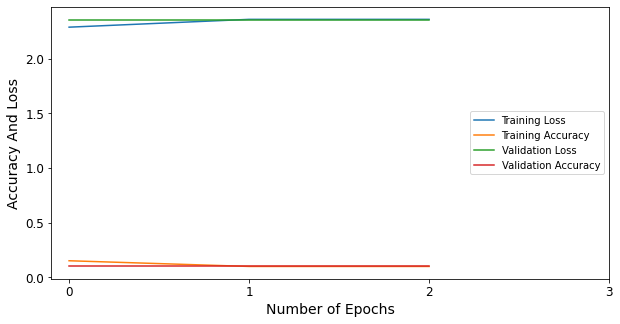

In [35]:
performace_metrics2(optim='Adam',lr=0.001)

## Summary for different matrics 

In [4]:

data = {'Optimizer and Learning rate':['SGD 0.1','SGD 0.01','SGD 0.001','ADAM 0.1','ADAM 0.01','ADAM 0.001'],
        'Training Loss':[2.30,  2.30,  2.30,  2.36,  2.36, 2.36],
        
        'Training Accuracy':[10.13, 9.99, 10.13, 9.97, 9.94, 9.94],
        
        'Validation Loss':[2.30,  2.30, 2.30,  2.35,  2.35,  2.35],
        
       'Validation_Accuracy':[9.45,  10.01,  9.45,  10.12, 10.22,  10.24]}  

df = pd.DataFrame(data, index =['Case 1', 'Case 2', 'Case 3', 'Case 4',"Case 5","Case 6"])

display(df)

print("From the table above we can see that respective network does not perform well and we have to modify it")

,Optimizer and Learning rate,Training Loss,Training Accuracy,Validation Loss,Validation_Accuracy
Case 1,SGD 0.1,2.30,10.13,2.30,9.45
Case 2,SGD 0.01,2.30,9.99,2.30,10.01
Case 3,SGD 0.001,2.30,10.13,2.30,9.45
Case 4,ADAM 0.1,2.36,9.97,2.35,10.12
Case 5,ADAM 0.01,2.36,9.94,2.35,10.22
Case 6,ADAM 0.001,2.36,9.94,2.35,10.24


From the table above we can see that respective network does not perform well and we have to modify it


### Network 2

####  Batch normalization, without dropout

In [36]:
def network2():
    model2=nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),  
    nn.BatchNorm2d(64),
    nn.ReLU(),
        
    nn.MaxPool2d(kernel_size=2, stride=2),  
        
        
        
    nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1), 
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
        
    nn.MaxPool2d(kernel_size=2, stride=2),

        
        
    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Conv2d(512,256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
        
    nn.MaxPool2d(kernel_size=2, stride=2),

        
        
    nn.Conv2d(256,128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128,64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
        
        
        
#     nn.MaxPool2d(kernel_size=2, stride=2),


    nn.Conv2d(64,32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
        
#     nn.MaxPool2d(kernel_size=2, stride=2),


    nn.Flatten(),
    nn.Linear(32*4*4, 10),  
    nn.Softmax(dim=1)
    )

    classification_loss = nn.CrossEntropyLoss() # We usually use crossEntrophy loss for classification problems

    return model2, classification_loss

In [37]:
model2_net2, classify_loss_net2=network2()

In [38]:
# with test data
def performance_metrics_net2(optim,lr):
    
    tr_loss=[]
    tr_acc=[]
    val_loss=[]
    val_acc=[]
    
    model2_net2, classify_loss_net2 = network2()
    optimizer=optimizers(model=model2_net2, opt=optim, learning_rate=lr)
    
    model2_net2 = model2_net2.to(device)

    for epoch in range(20):
        loss_tr,acc_tr=train(loader=trainloader, model=model2_net2, classify_loss=classify_loss_net2, opt=optimizer)
        
        loss_val,acc_val=validation(loader=valloader, model=model2_net2, classify_loss=classify_loss_net2, opt=optimizer)
       
        print("Epoch Number: ",epoch+1)
        print("\nTraining Loss: ",loss_tr)
        print("Training Accuracy: ",acc_tr)
        
        print("\nValidation Loss",loss_val)
        print("Validation Accuracy",acc_val)

        tr_loss.append(loss_tr)
        tr_acc.append(acc_tr)
        val_loss.append(loss_val)
        val_acc.append(acc_val)

        print('-----------------------------------')


    plt.figure(figsize=[10,5])

    plt.plot(tr_loss, linestyle='-',label="Training Loss")
    plt.plot(tr_acc,label="Training Accuracy")
    plt.plot(val_loss, label='Validation Loss')
    plt.plot(val_acc, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy And Loss')
    plt.xticks(np.arange(0,21,1))
#     plt.yticks(np.arange(0.1,,5))
    plt.legend(loc='center right')
    plt.show()
    
    loss_tst,acc_tst=validation(loader=testloader, model=model2_net2, classify_loss=classify_loss_net2, opt=optimizer)
    print('******************************************************************')
    print("Performance metrics on testing data")
    print(f"Test Data Accuracy:{acc_tst}|Loss on Test Data:{loss_tst}")

## Adam, 0.001

Epoch Number:  1

Training Loss:  2.0655948138237
Training Accuracy:  0.388

Validation Loss 2.0017741834774565
Validation Accuracy 0.455
-----------------------------------
Epoch Number:  2

Training Loss:  1.9518581329345703
Training Accuracy:  0.505025

Validation Loss 1.9422430230405765
Validation Accuracy 0.5136
-----------------------------------
Epoch Number:  3

Training Loss:  1.8907506558418274
Training Accuracy:  0.5675

Validation Loss 1.8560797086538978
Validation Accuracy 0.6028
-----------------------------------
Epoch Number:  4

Training Loss:  1.8468598227500916
Training Accuracy:  0.611525

Validation Loss 1.8208135884409895
Validation Accuracy 0.6371
-----------------------------------
Epoch Number:  5

Training Loss:  1.8085827634811402
Training Accuracy:  0.649975

Validation Loss 1.7811039952805248
Validation Accuracy 0.6796
-----------------------------------
Epoch Number:  6

Training Loss:  1.7816846085548401
Training Accuracy:  0.677

Validation Loss 1.769513

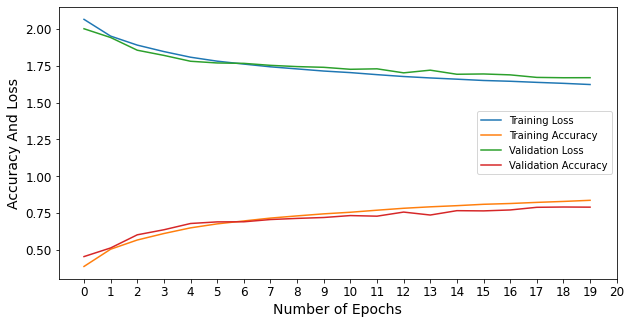

******************************************************************
Performance metrics on testing data
Test Data Accuracy:0.7964|Loss on Test Data:1.6634344079623968


In [40]:
performance_metrics_net2(optim='Adam',lr=0.001)

### Adam, 0.001, batch normalization, dropout

In [41]:
def network2_new():
    model2_new=nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
    nn.BatchNorm2d(32),
    nn.ReLU(),

    nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),  
    nn.BatchNorm2d(64),
    nn.ReLU(),
        
    nn.MaxPool2d(kernel_size=2, stride=2),  
        
        
        
    nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1), 
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128,256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
        
    nn.MaxPool2d(kernel_size=2, stride=2),

        
        
    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),

    nn.Conv2d(512,256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
        
    nn.MaxPool2d(kernel_size=2, stride=2),

        
        
    nn.Conv2d(256,128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128,64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
        
        
        
#     nn.MaxPool2d(kernel_size=2, stride=2),


    nn.Conv2d(64,32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
        
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(),   # DROPOUT



    nn.Flatten(),
    nn.Linear(32*2*2, 10),  
    nn.Softmax(dim=1)
    ).to(device)

    classification_loss = nn.CrossEntropyLoss() # We usually use crossEntrophy loss for classification problems

    return model2_new, classification_loss

In [42]:
base_model, classification_loss = network2_new()

In [43]:
def preformance_metrics1_net2_new(optim,lr):
    
    tr_loss=[]
    tr_acc=[]
    val_loss=[]
    val_acc=[]
    
    base_model, classification_loss = network2_new()
    optimizer=optimizers(model=base_model, opt=optim, learning_rate=lr)
    
    base_model = base_model.to(device)

    for epoch in range(20):
        loss_tr,acc_tr=train(loader=trainloader, model=base_model, classify_loss=classification_loss, opt=optimizer)
        
        loss_val,acc_val=validation(loader=valloader, model=base_model, classify_loss=classification_loss, opt=optimizer)
       
        print("Epoch Number: ",epoch+1)
        print("\nTraining Loss: ",loss_tr)
        print("Training Accuracy: ",acc_tr)
        
        print("\nValidation Loss",loss_val)
        print("Validation Accuracy",acc_val)

        tr_loss.append(loss_tr)
        tr_acc.append(acc_tr)
        val_loss.append(loss_val)
        val_acc.append(acc_val)

        print('-----------------------------------')


    plt.figure(figsize=[10,5])

    plt.plot(tr_loss, linestyle='-',label="Training Loss")
    plt.plot(tr_acc,label="Training Accuracy")
    plt.plot(val_loss, label='Validation Loss')
    plt.plot(val_acc, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy And Loss')
    plt.xticks(np.arange(0,21,1))
#     plt.yticks(np.arange(0.1,,5))
    plt.legend(loc='center right')
    plt.show()
    
    
    
    loss_tst,acc_tst=validation(loader=testloader, model=base_model, classify_loss=classification_loss, opt=optimizer)
    print('*************************************************************************')
    print("Performance metrics on testing data")
    print(f"Accuracy on Test Data:{acc_tst}|Loss on Test Data:{loss_tst}")

Epoch Number:  1

Training Loss:  2.074480002117157
Training Accuracy:  0.382275

Validation Loss 1.9765475382820106
Validation Accuracy 0.4832
-----------------------------------
Epoch Number:  2

Training Loss:  1.9535989303588868
Training Accuracy:  0.504675

Validation Loss 1.90149935594382
Validation Accuracy 0.5583
-----------------------------------
Epoch Number:  3

Training Loss:  1.8912333236694336
Training Accuracy:  0.56775

Validation Loss 1.8520561605215835
Validation Accuracy 0.6068
-----------------------------------
Epoch Number:  4

Training Loss:  1.8439753774642944
Training Accuracy:  0.61635

Validation Loss 1.8408575751149236
Validation Accuracy 0.6176
-----------------------------------
Epoch Number:  5

Training Loss:  1.8159400756835937
Training Accuracy:  0.643425

Validation Loss 1.808939588336518
Validation Accuracy 0.65
-----------------------------------
Epoch Number:  6

Training Loss:  1.7884209394454955
Training Accuracy:  0.672325

Validation Loss 1.77

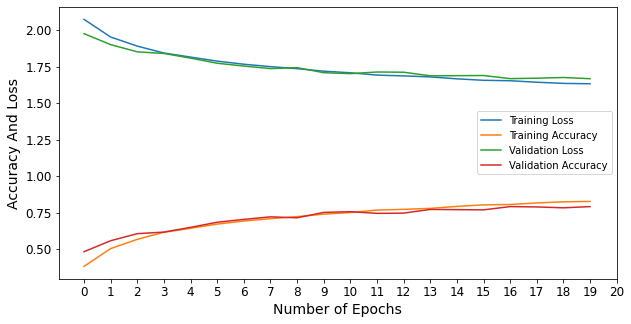

*************************************************************************
Performance metrics on testing data
Accuracy on Test Data:0.7907|Loss on Test Data:1.6694186590730953


In [44]:
preformance_metrics1_net2_new(optim='Adam',lr=0.001)

In [6]:
data = {'Optimizer and Learning rate':['ADAM 0.001','ADAM 0.001'],
        'Training Loss':[1.62, 1.63],
        
        'Training Accuracy':[83.7, 82.74],
        
        'Validation Loss':[1.66,  1.66],
        
       'Validation_Accuracy':[79.05,  79.21]}  

df = pd.DataFrame(data, index =['Without Dropout','With Dropout'])

print('Results below are on Training and validation data')
display(df)



data_test = {'Optimizer and Learning rate':['ADAM 0.001','ADAM 0.001'],
        'Testing Loss':[1.66,1.66],
        
        'Testing Accuracy':[79.64,79.07]}
        
print('Resuts below are on Test data')


df2 = pd.DataFrame(data_test, index =['Without Dropout','With Dropout'])
display(df2)


Results below are on Training and validation data


,Optimizer and Learning rate,Training Loss,Training Accuracy,Validation Loss,Validation_Accuracy
Without Dropout,ADAM 0.001,1.62,83.70,1.66,79.05
With Dropout,ADAM 0.001,1.63,82.74,1.66,79.21


Resuts below are on Test data


,Optimizer and Learning rate,Testing Loss,Testing Accuracy
Without Dropout,ADAM 0.001,1.66,79.64
With Dropout,ADAM 0.001,1.66,79.07


## Alexnet

In [75]:
alexnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True).to(device)
alexnet_model.eval()

Using cache found in /Users/rishabh/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [76]:
preprocess_alexnet = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


trainset_alexnet = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=preprocess_alexnet)

# trainloader_alexnet = torch.utils.data.DataLoader(trainset_alexnet, batch_size=32,
                                          shuffle=True, num_workers=2)

testset_alexnet = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=preprocess_alexnet)

testloader_alexnet = torch.utils.data.DataLoader(testset_alexnet, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [80]:
# Getting Validation set for alexnet
val_size = 10000
train_size = len(trainset_alexnet) - val_size
train_data,val_data = random_split(trainset_alexnet,[train_size,val_size])

In [81]:
trainloader_alexnet=torch.utils.data.DataLoader(train_data, batch_size=32,shuffle=True, num_workers=2)
valloader_alexnet=torch.utils.data.DataLoader(val_data, batch_size=32,shuffle=True, num_workers=2)

In [82]:
alexnet_model.classifier[4] = nn.Linear(4096,1024)
alexnet_model.classifier[6] = nn.Linear(1024,10)

In [83]:
alexnet_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [79]:
# criterion_alexnet = nn.CrossEntropyLoss()
# optimizer_alexnet = optim.SGD(alexnet_model.parameters(), lr=0.001, momentum=0.9)

In [51]:
def predict_before_train(model=alexnet_model, device=device, test_loader=testloader_alexnet):
    corrects = 0
    total = 0
    model = model.to(device)
    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device)
            test_outputs = model(test_inputs)
            test_preds = test_outputs.argmax(dim=1)
            total += test_labels.size(0)
            corrects += (test_preds==test_labels).sum().item()

    print('Accuracy of the network on the 10000 test images before training: %d %%' % (100 * corrects / total))

In [52]:
predict_before_train()

Accuracy of the network on the 10000 test images before training: 11 %


In [85]:
def alexnet_metrics(alex_model=alexnet_model):
    
    tr_loss=[]
    tr_acc=[]
    val_loss=[]
    val_acc=[]
    
#     base_model, classification_loss = network2_new()
#     optimizer=optimizers(model=base_model, opt="Adam", learning_rate=0.001)

    criterion_alexnet = nn.CrossEntropyLoss()
    optimizer_alexnet = optim.SGD(alexnet_model.parameters(), lr=0.001, momentum=0.9)

    

    model_ = alex_model.to(device)

    for epoch in range(4):
        loss_tr,acc_tr=train(loader=trainloader_alexnet, model=model_, classify_loss=criterion_alexnet, opt=optimizer_alexnet)
        
        loss_val,acc_val=validation(loader=valloader_alexnet, model=model_, classify_loss=criterion_alexnet, opt=optimizer_alexnet)
       
        print("Epoch Number: ",epoch+1)
        print("\nTraining Loss: ",loss_tr)
        print("Training Accuracy: ",acc_tr)
        
        print("\nValidation Loss",loss_val)
        print("Validation Accuracy",acc_val)

        tr_loss.append(loss_tr)
        tr_acc.append(acc_tr)
        val_loss.append(loss_val)
        val_acc.append(acc_val)

        print('-----------------------------------')


    plt.figure(figsize=[10,5])

    plt.plot(tr_loss, linestyle='-',label="Training Loss")
    plt.plot(tr_acc,label="Training Accuracy")
    plt.plot(val_loss, label='Validation Loss')
    plt.plot(val_acc, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy And Loss')
    plt.xticks(np.arange(0,5,1))
#     plt.yticks(np.arange(0.1,,5))
    plt.legend(loc='center right')
    plt.show()
    
    
    loss_tst,acc_tst=validation(loader=testloader_alexnet, model=model_, classify_loss=criterion_alexnet, opt=optimizer_alexnet)
    print('*************************************************************************')
    print("Performance metrics on testing data after training")
    print(f"Accuracy on Test Data:{acc_tst}|Loss on Test Data:{loss_tst}")

Epoch Number:  1

Training Loss:  0.7414934666752815
Training Accuracy:  0.74015

Validation Loss 0.5098171726868937
Validation Accuracy 0.8243
-----------------------------------
Epoch Number:  2

Training Loss:  0.47431072930693624
Training Accuracy:  0.834475

Validation Loss 0.41872910931468393
Validation Accuracy 0.859
-----------------------------------
Epoch Number:  3

Training Loss:  0.37832770624160766
Training Accuracy:  0.8666

Validation Loss 0.4221451799281108
Validation Accuracy 0.8612
-----------------------------------
Epoch Number:  4

Training Loss:  0.31141420320272445
Training Accuracy:  0.8917

Validation Loss 0.31333643333694805
Validation Accuracy 0.8909
-----------------------------------


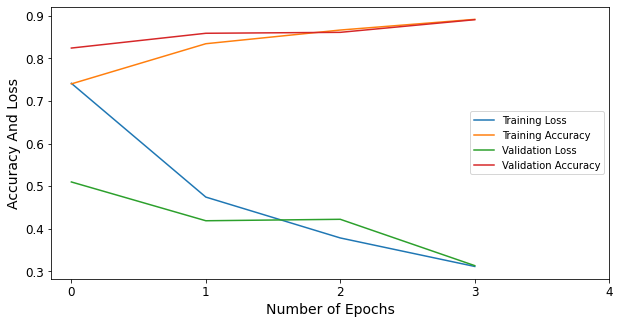

*************************************************************************
Performance metrics on testing data after training
Accuracy on Test Data:0.8901|Loss on Test Data:0.3183226055159165


In [86]:
alexnet_metrics()

## ResNet

In [55]:
from torchvision.models import ResNet18_Weights
resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18',weights=ResNet18_Weights.DEFAULT).to(device)

Using cache found in /Users/rishabh/.cache/torch/hub/pytorch_vision_v0.10.0


In [56]:
# Loading the data again because the preprocessing is different
preprocess_resnet = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


trainset_resnet = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=preprocess_resnet)

# trainloader_vgg19 = torch.utils.data.DataLoader(trainset_vgg19, batch_size=32,
#                                           shuffle=True, num_workers=2)

testset_resnet = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=preprocess_resnet)

testloader_resnet = torch.utils.data.DataLoader(testset_resnet, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [57]:
# Getting Validation set for resnet
val_size = 10000
train_size = len(trainset_resnet) - val_size
train_data,val_data = random_split(trainset_resnet,[train_size,val_size])

In [58]:
trainloader_resnet=torch.utils.data.DataLoader(train_data, batch_size=32,shuffle=True, num_workers=2)
valloader_resnet=torch.utils.data.DataLoader(val_data, batch_size=32,shuffle=True, num_workers=2)

In [59]:
# resnet_model.eval()

In [60]:
resnet_model.fc = nn.Linear(512,10)

In [61]:
# resnet_model.eval()

In [62]:
# criterion_resnet = nn.CrossEntropyLoss()
# optimizer_resnet = optim.SGD(resnet_model.parameters(), lr=0.001, momentum=0.9)

In [63]:
predict_before_train(model=resnet_model, device=device, test_loader=testloader_resnet)

Accuracy of the network on the 10000 test images before training: 8 %


In [64]:
def resnet_metrics(model_res=resnet_model):
    
    
    
    criterion_resnet = nn.CrossEntropyLoss()
    optimizer_resnet = optim.SGD(model_res.parameters(), lr=0.001, momentum=0.9)
    
    
    # testing before predict 
    
#     loss_tst_before_train,acc_tst_before_train=validation(loader=testloader_resnet, model=model_res, classify_loss=criterion_resnet, opt=optimizer_resnet)
#     print("Performance metrics on testing data before training")
#     print(f"Accuracy on Test Data:{acc_tst_before_train}|Loss on Test Data:{loss_tst_before_train}")
    
    
#     print('-------------------------------------------')
    
    tr_loss=[]
    tr_acc=[]
    val_loss=[]
    val_acc=[]

#     criterion_resnet = nn.CrossEntropyLoss()
#     optimizer_resnet = optim.SGD(model_res.parameters(), lr=0.001, momentum=0.9)
    
    
    
    model_res = model_res.to(device)


    for epoch in range(3):
        loss_tr,acc_tr=train(loader=trainloader_resnet, model=model_res, classify_loss=criterion_resnet, opt=optimizer_resnet)
        
        loss_val,acc_val=validation(loader=valloader_resnet, model=model_res, classify_loss=criterion_resnet, opt=optimizer_resnet)
       
        print("Epoch Number: ",epoch+1)
        print("\nTraining Loss: ",loss_tr)
        print("Training Accuracy: ",acc_tr)
        
        print("\nValidation Loss",loss_val)
        print("Validation Accuracy",acc_val)

        tr_loss.append(loss_tr)
        tr_acc.append(acc_tr)
        val_loss.append(loss_val)
        val_acc.append(acc_val)

        print('-----------------------------------')


    plt.figure(figsize=[10,5])

    plt.plot(tr_loss, linestyle='-',label="Training Loss")
    plt.plot(tr_acc,label="Training Accuracy")
    plt.plot(val_loss, label='Validation Loss')
    plt.plot(val_acc, label='Validation Accuracy')

    plt.xlabel("Number of Epochs")
    plt.ylabel('Accuracy And Loss')
    plt.xticks(np.arange(0,4,1))
#     plt.yticks(np.arange(0.1,,5))
    plt.legend(loc='center right')
    plt.show()
    
    
    loss_tst,acc_tst=validation(loader=testloader_resnet, model=model_res, classify_loss=criterion_resnet, opt=optimizer_resnet)
    print('**********************************************************************')
    print("Performance metrics on testing data after training")
    print(f"Accuracy on Test Data:{acc_tst}|Loss on Test Data:{loss_tst}")

Epoch Number:  1

Training Loss:  0.5002615999102592
Training Accuracy:  0.8342

Validation Loss 0.2361430740965822
Validation Accuracy 0.9224
-----------------------------------
Epoch Number:  2

Training Loss:  0.1900986974403262
Training Accuracy:  0.936875

Validation Loss 0.19827505805122014
Validation Accuracy 0.9323
-----------------------------------
Epoch Number:  3

Training Loss:  0.10281512138098478
Training Accuracy:  0.96655

Validation Loss 0.1794812369306152
Validation Accuracy 0.9408
-----------------------------------


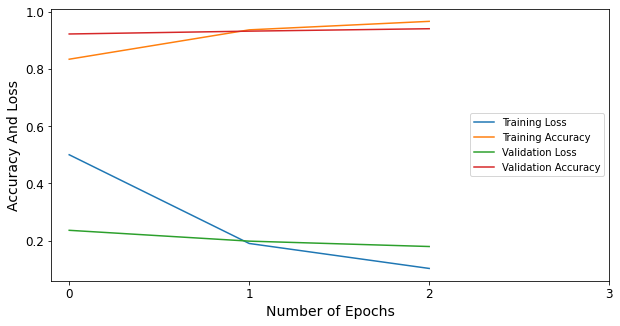

**********************************************************************
Performance metrics on testing data after training
Accuracy on Test Data:0.938|Loss on Test Data:0.18936115008787796


In [65]:
resnet_metrics()